This notebook provides an introduction to the basic ideas of graph theory.

Before running this you will  need to install the python brain connectivity toolbox:

pip install git+git://github.com/aestrivex/bctpy

In [7]:
import sys,os
from collections import Counter

import numpy,pandas
import scipy.stats
import networkx
import nilearn.plotting
import matplotlib.pyplot as plt
sys.path.append('/home/vagrant/fmri-analysis-vm/analysis/utils')
from community.community_louvain import modularity,best_partition
import bct

%matplotlib inline


First let's generate a network by specifying it as a matrix.  We will start with a simple binary network with 5 nodes, where every node is either connected (1) or not (0). 

[[ 0.  1.  1.  1.  0.  0.  0.]
 [ 1.  0.  1.  0.  0.  0.  0.]
 [ 1.  1.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  1.  1.  1.]
 [ 0.  0.  0.  1.  0.  1.  1.]
 [ 0.  0.  0.  1.  1.  0.  1.]
 [ 0.  0.  0.  1.  1.  1.  0.]]


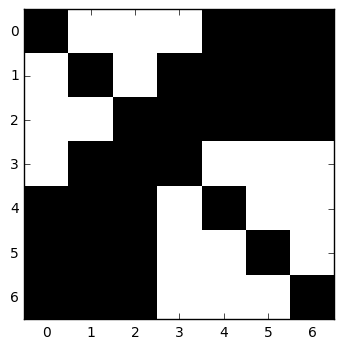

In [25]:
adj=numpy.zeros((7,7))  # empty adjacency matrix
# now specify each 
edges=[[0,1],[0,2],[1,2],[0,3],[3,4],[3,5],[4,5],[3,6],[4,6],[5,6]]
for e in edges:
    adj[e[0],e[1]]=1
adj=adj+adj.T
print(adj)
plt.imshow(adj,interpolation='nearest',cmap='gray')


Now we take this matrix and create a graph using networkx.

In [9]:
G=networkx.from_numpy_matrix(adj).to_undirected()
print('nodes:',G.nodes())
print('edges:',G.edges())

nodes: [0, 1, 2, 3, 4, 5, 6]
edges: [(0, 1), (0, 2), (0, 3), (1, 2), (3, 4), (3, 5), (3, 6), (4, 5), (4, 6), (5, 6)]


Visualize the network using a spring-embedded display.

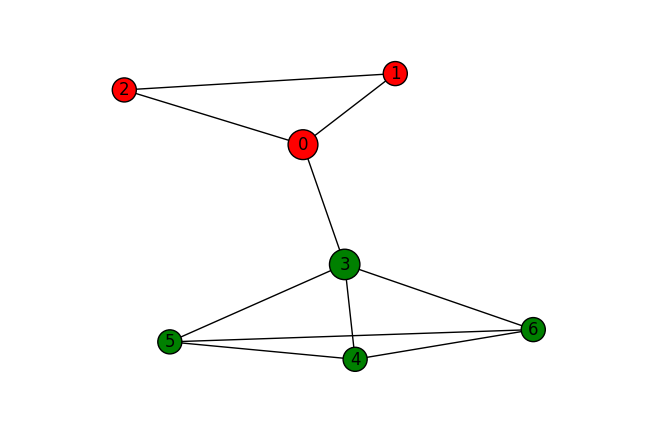

In [10]:
comm=best_partition(G)
membership=numpy.array([comm[i] for i in range(7)])
bc=networkx.betweenness_centrality(G)
participation=bct.participation_coef(adj,membership)
centrality=numpy.array([bc[i] for i in range(7)])
colorvals=['r','g']
networkx.draw_spring(G,with_labels=True,
                     node_color=[colorvals[i] for i in membership],
                    node_size=centrality*300+300)

Print out some graph statistics about the nodes, and perform community detection using the Louvain algorithm.

In [11]:
print('modularity=',modularity(comm,G))
nodeinfo=pandas.DataFrame({'degree':G.degree(),
                           'clustering':networkx.clustering(G)})
nodeinfo['partition']=membership
nodeinfo['betweeness_centrality']=centrality
nodeinfo['participation']=participation
print(nodeinfo)

modularity= 0.3549999999999999
   clustering  degree  partition  betweeness_centrality  participation
0    0.333333       3          0               0.533333       0.444444
1    1.000000       2          0               0.000000       0.000000
2    1.000000       2          0               0.000000       0.000000
3    0.500000       4          1               0.600000       0.375000
4    1.000000       3          1               0.000000       0.000000
5    1.000000       3          1               0.000000       0.000000
6    1.000000       3          1               0.000000       0.000000


Now let's look at a more complex graph.  We will read in the adjacency matrix from the myconnectome data, threshold it at a particular density, binarize it, and then display it and compute its modularity.

In [16]:
columns=['roinum','hemis','X','Y','Z',
          'lobe','region','powernet','yeo7net','yeo17net']
parceldata=pandas.DataFrame.from_csv('ds031_connectome/parcel_data.txt',
                                     sep='\t',header=None,index_col=None)

parceldata.columns=columns

cc_utr=numpy.load('ds031_connectome/meancorr_utr.npy')
cc=numpy.zeros((630,630))
cc[numpy.triu_indices(630,1)]=cc_utr
cc=cc+cc.T  # make it symmetric
density=0.1 # density of the graph
threshold=scipy.stats.scoreatpercentile(cc_utr,100-density*100)
cc_adj=(cc>threshold).astype('int')
G=networkx.from_numpy_matrix(cc_adj)
# add network labels
powernet_dict={}
yeo7_dict={}
coord_dict={}
for n in G.nodes():
    powernet_dict[n]=parceldata.powernet.ix[n]
    yeo7_dict[n]=parceldata.yeo7net.ix[n]
    coord_dict[n]=[parceldata.X.ix[n],parceldata.Y.ix[n],parceldata.Z.ix[n]]
networkx.set_node_attributes(G,'powernet',powernet_dict)
networkx.set_node_attributes(G,'yeo7',yeo7_dict)
networkx.set_node_attributes(G,'coords',coord_dict)

# get the giant component
Gcc=sorted(networkx.connected_component_subgraphs(G), key = len, reverse=True)
G0=Gcc[0]
adj_G0=numpy.array(networkx.to_numpy_matrix(G0))
pos=networkx.spring_layout(G0)
partition=best_partition(G0,resolution=0.5)
membership=numpy.array([partition[i] for i in G0.nodes()])
m=modularity(partition,G0)
print('modularity:',m)
eff=bct.efficiency_bin(cc_adj)
print('efficiency:',eff)
bc=networkx.betweenness_centrality(G)
centrality=numpy.array([bc[i] for i in range(len(G.nodes()))])
participation=bct.participation_coef(adj_G0,membership)

modularity: 0.5264349332834273
efficiency: 0.404213947841


In [3]:
# figure out which networks are contained in each community

nc=[]
minsize=5
communities=numpy.array(list(partition.values()))
powernets=[G.node[i]['powernet'] for i in G.nodes()]
yeo7nets=[G.node[i]['yeo7'] for i in G.nodes()]
for c in numpy.unique(communities):
    count=numpy.sum(communities==c)
    nc.append(count)
    if count<minsize:
        communities[communities==c]=-1
        continue
    powernets_community=[powernets[i] for i in range(len(communities)) if communities[i]==c]
    print('community',c)
    pcount=Counter(powernets_community).most_common(4)
    for p in pcount:
        print([p[0],p[1]])
    print()


community 0
['DMN', 16]
['Frontoparietal_1', 14]
['Visual_2', 13]
['Parieto_occipital', 13]

community 1
['Somatomotor', 51]
['Cingulo_opercular', 12]
['Frontoparietal_1', 5]
['Visual_2', 3]

community 2
['Ventral_Attention', 10]
['Cingulo_opercular', 6]
['Frontoparietal_1', 6]
['DMN', 4]

community 3
['Visual_2', 24]
['Frontoparietal_1', 17]
['Zero', 11]
['Cingulo_opercular', 8]

community 4
['Frontoparietal_1', 52]
['Zero', 20]
['Somatomotor', 14]
['Visual_2', 13]

community 5
['Zero', 9]
['Visual_2', 8]
['Frontoparietal_1', 3]
['Visual_1', 2]

community 6
['Cingulo_opercular', 65]
['Frontoparietal_1', 11]
['Somatomotor', 11]
['DMN', 10]

community 7
['Somatomotor', 3]
['Cingulo_opercular', 2]
['Zero', 1]



[-0.2, 1.2, -0.1, 0.9]

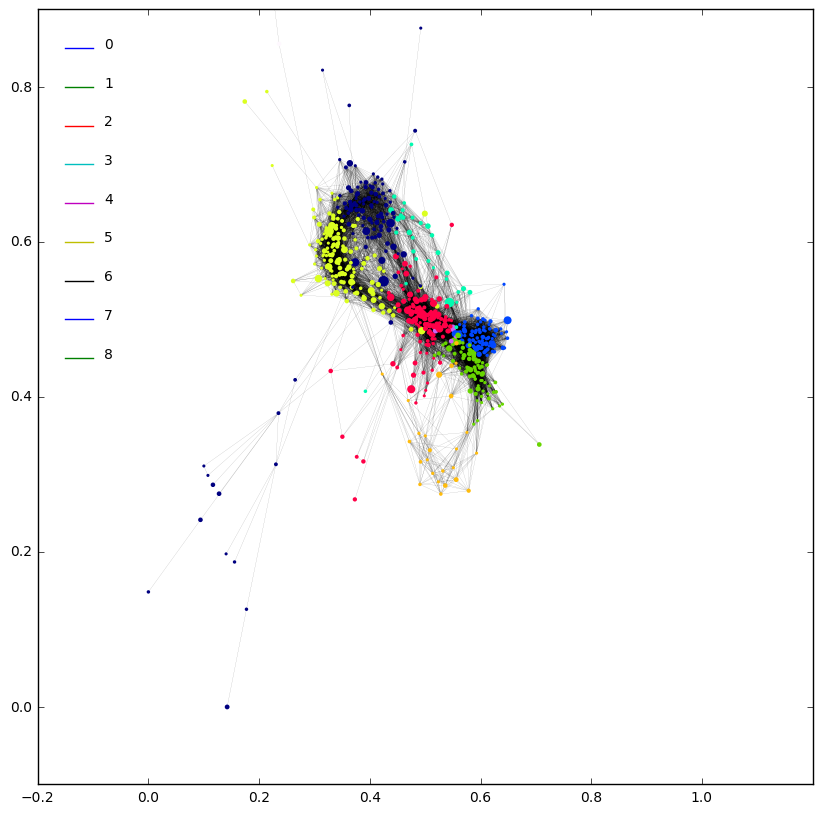

In [24]:
plt.figure(figsize=(10,10))
color_by='community'
if color_by=='community':
    colors=membership
elif color_by=='yeo7':
    colors=[]
    for i in G0.nodes():
        try:
            colors.append(int(G0.node[i]['yeo7'].split('_')[1]) )
        except:
            colors.append(0)
networkx.draw_networkx(G0,pos=pos,width=0.05,cmap=plt.get_cmap('gist_ncar'),
              node_color=colors, vmin=numpy.min(colors),vmax=numpy.max(colors),
                      with_labels=False,linewidths=0,
                      node_size=2000*centrality+5)

for i,c in enumerate(numpy.unique(colors)):
    y=0.85-i*0.05
    plt.plot([-0.15,-0.1],[y,y])
    plt.text(-0.08,y,'%d'%c)
plt.axis([-0.2,1.2,-0.1,0.9])

We can also use the nilearn plotting tools to plot one of the networks.

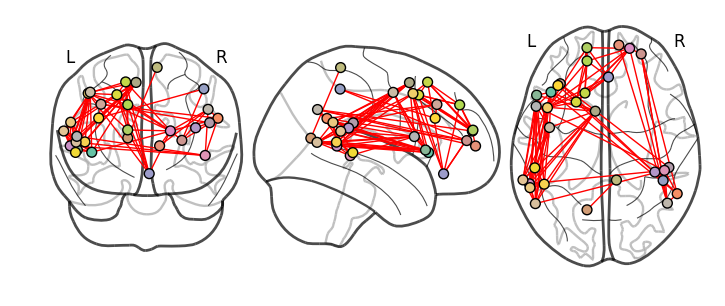

In [61]:
subnet=2
subnet_nodes=[i for i in range(len(colors)) if colors[i]==subnet]
sg=G.subgraph(subnet_nodes)
sg_adjmtx=networkx.to_numpy_matrix(sg).astype('float')
# this is a kludge - for some reason nilearn can't handle
# the matrix that networkx generates
adjmtx=numpy.zeros((sg_adjmtx.shape[0],sg_adjmtx.shape[0]))
for i in range(sg_adjmtx.shape[0]):
    for j in range(sg_adjmtx.shape[0]):
        adjmtx[i,j]=sg_adjmtx[i,j]
node_coords=numpy.array([sg.node[i]['coords'] for i in sg.nodes()])
nilearn.plotting.plot_connectome(adjmtx,node_coords,
                                edge_threshold='75%',edge_kwargs={'linewidth':1})

Let's look at the same network as a matrix, sorting by the Power et al. networks assigned in the original analysis of the data.

[0, 630, 630, 0]

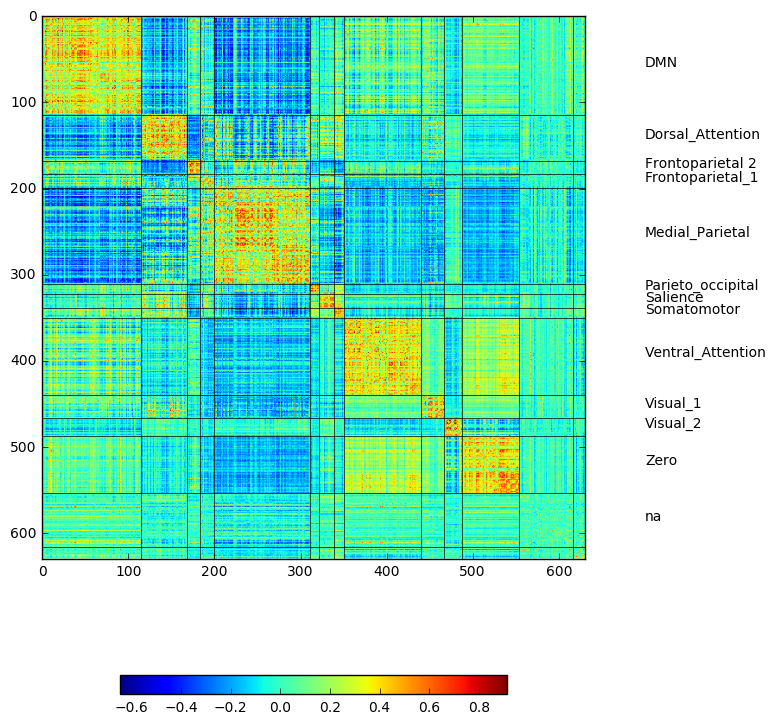

In [212]:
fig=plt.figure(figsize=(10,10))
idx=parceldata.powernet.argsort().values
powernet=parceldata.powernet.copy()
powernet.values.tolist()
powernet_sorted=[powernet[i] for i in idx]
breakpoints=[i for i in range(1,len(powernet_sorted)) if powernet_sorted[i]!=powernet_sorted[i-1]]
meancc_reorder=cc[idx,:]
meancc_reorder=meancc_reorder[:,idx]
plt.imshow(meancc_reorder,origin='upper')

for i,b in enumerate(breakpoints):
    if i==0:
        pos=b/2
    else:
        pos=(b+breakpoints[i-1])/2
    plt.text(700,pos,powernet_sorted[b])
    plt.plot([0,630],[b,b],'k',linewidth=0.5)
    plt.plot([b,b],[0,630],'k',linewidth=0.5)
plt.colorbar(orientation='horizontal',shrink=0.5)
plt.axis([0,630,630,0])

Now let's randomize the connections and look at the graph.

In [132]:
cc_rand=numpy.zeros((630,630))
cc_utr_rand=cc_utr.copy()
numpy.random.shuffle(cc_utr_rand)
cc_rand[numpy.triu_indices(630,1)]=cc_utr_rand
cc_rand=cc_rand+cc_rand.T  # make it symmetric
cc_rand_adj=(cc_rand>threshold).astype('int')
G_rand=networkx.from_numpy_matrix(cc_rand_adj)
# get the giant component
Gcc_rand=sorted(networkx.connected_component_subgraphs(G_rand), key = len, reverse=True)
G0_rand=Gcc_rand[0]
pos_rand=networkx.spring_layout(G0_rand)
partition=best_partition(G0_rand)
m_rand=modularity(partition,G0_rand)
print('modularity:',m_rand)
eff_rand=bct.efficiency_bin(cc_rand_adj)
print('efficiency:',eff_rand)
bc_rand=networkx.betweenness_centrality(G_rand)
centrality_rand=numpy.array([bc_rand[i] for i in range(len(G_rand.nodes()))])


modularity: 0.10126158486399543
efficiency: 0.549727037962


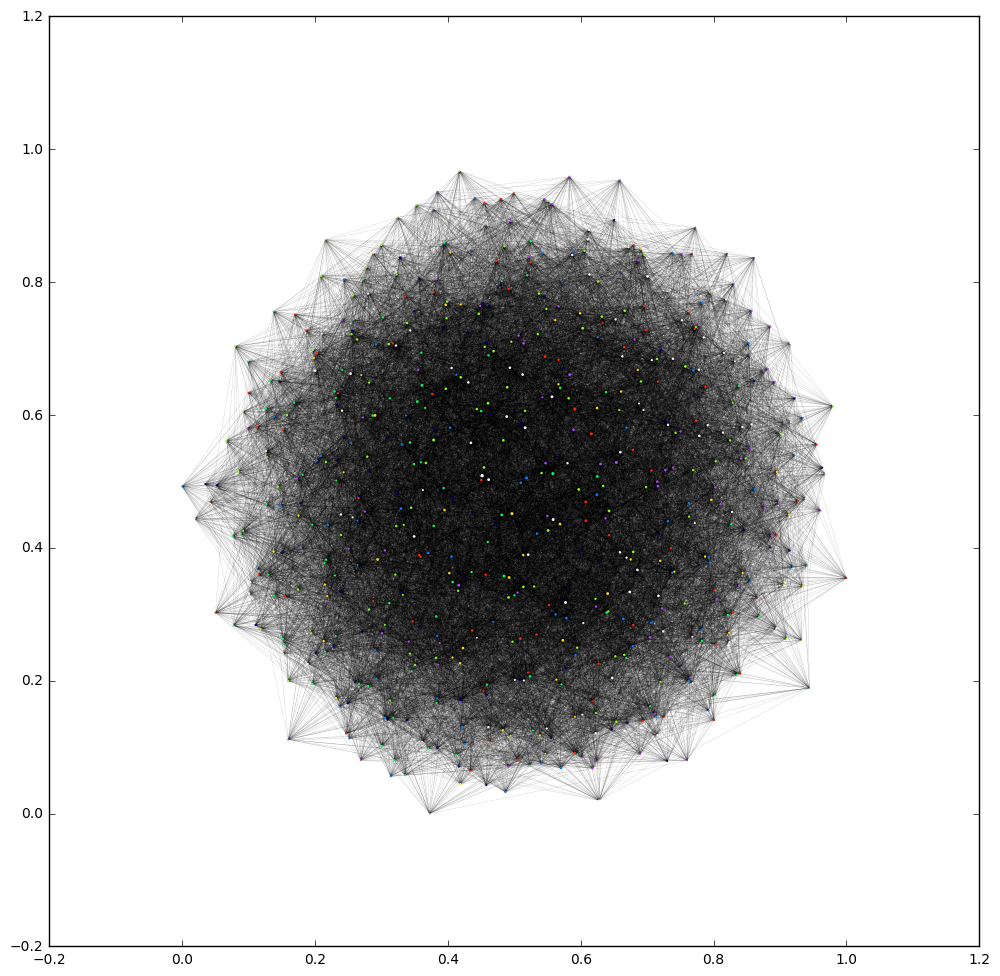

In [133]:
plt.figure(figsize=(12,12))
colors=numpy.array([partition[i] for i in G0_rand.nodes()])
networkx.draw_networkx(G0_rand,pos=pos_rand,width=0.05,cmap=plt.get_cmap('gist_ncar'),
              node_color=colors, vmin=numpy.min(colors),vmax=numpy.max(colors),
                      with_labels=False,linewidths=0,
                      node_size=2000*centrality_rand)

Plot the degree distributions for the origin and randomized networks

In [112]:
degree_hist=numpy.histogram(list(G.degree().values()),50)
degree_hist_rand=numpy.histogram(list(G_rand.degree().values()),50)

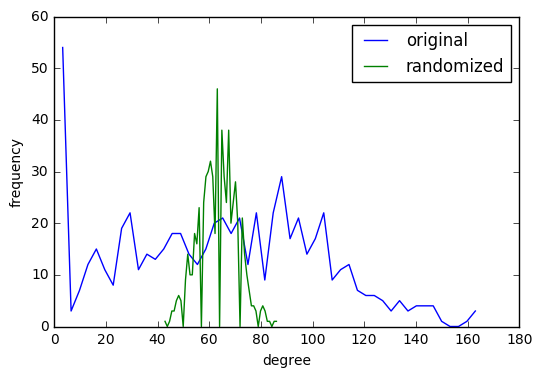

In [115]:
plt.plot(degree_hist[1][1:],degree_hist[0])
plt.plot(degree_hist_rand[1][1:],degree_hist_rand[0])
plt.legend(['original','randomized'])
plt.ylabel('frequency')
plt.xlabel('degree')